## Commit

Running the cell below copies any local source code modifications into the FlashAttention install directory on the FlashAttention docker image, and then commits the Docker image.

In [1]:
!./build_commit.sh

"docker kill" requires at least 1 argument.
See 'docker kill --help'.

Usage:  docker kill [OPTIONS] CONTAINER [CONTAINER...]

Kill one or more running containers
Untagged: flash:flattened_live
Deleted: sha256:ad79216e9054cefdb3c7313c3b122aa63c450cbb16886981fb9148ce2631e3ba
Creating flash-attention_flashattention_run ... 
ting flash-attention_flashattention_run ... done

torch.__version__  = 1.14.0a0+410ce96


running install
running bdist_egg
running egg_info
writing flash_attn.egg-info/PKG-INFO
writing dependency_links to flash_attn.egg-info/dependency_links.txt
writing requirements to flash_attn.egg-info/requires.txt
writing top-level names to flash_attn.egg-info/top_level.txt
reading manifest file 'flash_attn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
/usr/local/lib/python3.8/dist-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/usr/local/l

byte-compiling build/bdist.linux-x86_64/egg/flash_attn/models/vit.py to vit.cpython-38.pyc
byte-compiling build/bdist.linux-x86_64/egg/flash_attn/models/opt.py to opt.cpython-38.pyc
creating stub loader for flash_attn_cuda.cpython-38-x86_64-linux-gnu.so
byte-compiling build/bdist.linux-x86_64/egg/flash_attn_cuda.py to flash_attn_cuda.cpython-38.pyc
creating build/bdist.linux-x86_64/egg/EGG-INFO
copying flash_attn.egg-info/PKG-INFO -> build/bdist.linux-x86_64/egg/EGG-INFO
copying flash_attn.egg-info/SOURCES.txt -> build/bdist.linux-x86_64/egg/EGG-INFO
copying flash_attn.egg-info/dependency_links.txt -> build/bdist.linux-x86_64/egg/EGG-INFO
copying flash_attn.egg-info/requires.txt -> build/bdist.linux-x86_64/egg/EGG-INFO
copying flash_attn.egg-info/top_level.txt -> build/bdist.linux-x86_64/egg/EGG-INFO
writing build/bdist.linux-x86_64/egg/EGG-INFO/native_libs.txt
zip_safe flag not set; analyzing archive contents...
__pycache__.flash_attn_cuda.cpython-38: module references __file__
creati

## Testing

In [2]:
!echo "pytest tests/test_flash_attn_onewritehead.py"  | docker-compose run flashattention

Creating flash-attention_flashattention_run ... 
ting flash-attention_flashattention_run ... done============================= test session starts ==============================
platform linux -- Python 3.8.10, pytest-7.2.0, pluggy-1.0.0
rootdir: /home/workspace
plugins: rerunfailures-10.3, xdoctest-1.0.2, hypothesis-5.35.1, xdist-3.1.0, shard-0.1.2, hydra-core-1.3.1
collected 2 items
Running 2 items in this shard

tests/test_flash_attn_onewritehead.py ..                                 [100%]

============================== 2 passed in 26.88s ==============================


## Benchmark automation

Automate calls to run benchmarks using the Docker image.

In [30]:
import os

def parse_causal_benchmark(fn="bench_causal.log"):
    causal_data={}
    with open("bench_causal.log","r") as fp:
        att_type=""
        pass_dir=""
        bypass=0
        time_str=""
        for ln in fp:
            #print(ln)        
            if bypass >1:
                #print("<pass",bypass,">")            
                bypass-=1 #Ignore lines until bypass==1
            elif bypass == 1:
                #Collect runtime measurement
                #print("record")
                time_str=ln.split()[0]
                time_float=float(time_str)
                unit_str=ln.split()[1]
                if "us" in unit_str:
                    #print("Detected us in line:",ln,"att_type:",att_type,"pass_dir:",pass_dir)
                    time_float *= 0.001 # us to ms
                    #print("Resolved to",time_float,"ms")
                causal_data[att_type+pass_dir]=time_float
                bypass=0
                #print(float(time_str))
            else:
                if "MaxMemory" in ln:
                    # Assume attention type has already been determined
                    mem_str=ln.split(":")[1].split("GB")[0]
                    mem_float=float(mem_str)
                    causal_data[att_type+pass_dir+"MaxMemory"]=mem_float
                elif "FlashAttention Triton OWH" in ln:
                    #print("FlashAttention triton owh")
                    # Identify attention type and direction for experiment
                    att_type="FlashAttention Triton OWH"
                    pass_dir=ln.split("-")[1][1:].strip()
                    bypass=3            
                elif "FlashAttention Triton OG" in ln:
                    #print("FlashAttention triton og")
                    # Identify attention type and direction for experiment
                    att_type="FlashAttention Triton OG"
                    pass_dir=ln.split("-")[1][1:].strip()
                    bypass=3
                elif "FlashAttention Triton" in ln:
                    #print("FlashAttention triton")
                    # Identify attention type and direction for experiment
                    att_type="FlashAttention Triton"
                    pass_dir=ln.split("-")[1][1:].strip()
                    bypass=3                
                    #print(att_type)
                    #print(pass_dir)
                elif "FlashAttention" in ln:
                    # Identify attention type and direction for experiment
                    att_type="FlashAttention"
                    pass_dir=ln.split("-")[1][1:].strip()
                    bypass=3
                    #print(att_type)
                    #print(pass_dir)
                if "PyTorch Attention" in ln:
                    # Identify attention type and direction for experiment
                    att_type="StandardAttention"
                    pass_dir=ln.split("-")[1][1:].strip()
                    bypass=3
                    #print(att_type)
                    #print(pass_dir)
    return causal_data

def benchmark_causal(cfg={},fn="bench_causal.log"):
    opts=" "
    if "repeats" in cfg:
        opts += " -r " + str(cfg["repeats"])
    if "batch_size" in cfg:
        opts += " -b " + str(cfg["batch_size"])
    if "seqlen" in cfg:
        opts += " -m " + str(cfg["seqlen"])
    if "nheads" in cfg:
        opts += " -e " + str(cfg["nheads"])
    if "headdim" in cfg:
        opts += " -k " + str(cfg["headdim"])
    opts += " "
    
    base_cmd="echo \"PYTHONPATH=$PWD python3 benchmarks/benchmark_causal.py\""
    env=" | docker-compose run flashattention "
    outp= " > " + fn
 
    cmd=base_cmd + opts + env + outp
    print(cmd)
    os.system(cmd)
    causal_data=parse_causal_benchmark(fn)
    print(causal_data)
    return causal_data

## Sweep

### RTX 3090 speedup & memory vs sequence length

* batch_size=12
* nheads=12
* From A100 result - headdim=64
* seqlen = 128 - 4096
* Keep repeats=30

Authors' note: "Memory savings are the same as on an A100", "We see slightly higher speedups (between 2.5-4.5x) on the GTX 3090, since memory bandwidth on the GDDR6X is lower than A100 HBM (~900 GB/s vs. ~1.5 TB/s)."

In [31]:
cfg={}
cfg["batch_size"]=12
cfg["nheads"]=12
cfg["headdim"]=64


seqlen=[128,256,512,1024, 2048] #4096 exceeds 3090 24GB memory

res=[]

for sl in seqlen:
    print("seqlen=",sl)
    cfg["seqlen"]=sl
    print("cfg:",cfg)
    res.append(benchmark_causal(cfg))

seqlen= 128
cfg: {'batch_size': 12, 'nheads': 12, 'headdim': 64, 'seqlen': 128}
echo "PYTHONPATH=$PWD python3 benchmarks/benchmark_causal.py"  -b 12 -m 128 -e 12 -k 64  | docker-compose run flashattention  > bench_causal.log


Creating flash-attention_flashattention_run ... 
Creating flash-attention_flashattention_run ... done
STAGE:2023-05-26 13:59:40 7:7 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-05-26 13:59:40 7:7 ActivityProfilerController.cpp:300] Completed Stage: Collection
[W collection.cpp:655] Warning: Failed to recover relationship between all profiler and kineto events: 12 vs. 0  reassociated. (function reassociate)
STAGE:2023-05-26 13:59:43 7:7 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-05-26 13:59:43 7:7 ActivityProfilerController.cpp:300] Completed Stage: Collection
[W collection.cpp:655] Warning: Failed to recover relationship between all profiler and kineto events: 16 vs. 0  reassociated. (function reassociate)


{'FlashAttentionForward pass': 0.05148, 'FlashAttentionBackward pass': 0.14364, 'FlashAttentionForward + Backward pass': 0.22911, 'FlashAttentionForward + Backward passMaxMemory': 0.0135712890625, 'StandardAttentionForward pass': 0.25354, 'StandardAttentionBackward pass': 0.20381000000000002, 'StandardAttentionForward + Backward pass': 0.6579900000000001, 'StandardAttentionForward + Backward passMaxMemory': 0.04006298828125, 'FlashAttention TritonForward pass': 0.18356, 'FlashAttention TritonBackward pass': 0.65637, 'FlashAttention TritonForward + Backward pass': 0.39287, 'FlashAttention TritonForward + Backward passMaxMemory': 0.03128173828125, 'FlashAttention Triton OWHForward pass': 0.11627, 'FlashAttention Triton OWHBackward pass': 0.30707999999999996, 'FlashAttention Triton OWHForward + Backward pass': 0.78637, 'FlashAttention Triton OWHForward + Backward passMaxMemory': 0.04567236328125}
seqlen= 256
cfg: {'batch_size': 12, 'nheads': 12, 'headdim': 64, 'seqlen': 256}
echo "PYTHONP

Creating flash-attention_flashattention_run ... 
Creating flash-attention_flashattention_run ... done
STAGE:2023-05-26 13:59:53 7:7 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-05-26 13:59:53 7:7 ActivityProfilerController.cpp:300] Completed Stage: Collection
[W collection.cpp:655] Warning: Failed to recover relationship between all profiler and kineto events: 12 vs. 0  reassociated. (function reassociate)
STAGE:2023-05-26 13:59:56 7:7 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-05-26 13:59:56 7:7 ActivityProfilerController.cpp:300] Completed Stage: Collection
[W collection.cpp:655] Warning: Failed to recover relationship between all profiler and kineto events: 16 vs. 0  reassociated. (function reassociate)


{'FlashAttentionForward pass': 0.13166999999999998, 'FlashAttentionBackward pass': 0.29270999999999997, 'FlashAttentionForward + Backward pass': 0.43801, 'FlashAttentionForward + Backward passMaxMemory': 0.0366416015625, 'StandardAttentionForward pass': 0.26106, 'StandardAttentionBackward pass': 0.44597000000000003, 'StandardAttentionForward + Backward pass': 0.70598, 'StandardAttentionForward + Backward passMaxMemory': 0.08975048828125, 'FlashAttention TritonForward pass': 0.14576, 'FlashAttention TritonBackward pass': 0.25075000000000003, 'FlashAttention TritonForward + Backward pass': 0.6645800000000001, 'FlashAttention TritonForward + Backward passMaxMemory': 0.05406298828125, 'FlashAttention Triton OWHForward pass': 0.11718, 'FlashAttention Triton OWHBackward pass': 0.68463, 'FlashAttention Triton OWHForward + Backward pass': 0.44506, 'FlashAttention Triton OWHForward + Backward passMaxMemory': 0.08334423828125}
seqlen= 512
cfg: {'batch_size': 12, 'nheads': 12, 'headdim': 64, 'seq

Creating flash-attention_flashattention_run ... 
Creating flash-attention_flashattention_run ... done
STAGE:2023-05-26 14:00:06 7:7 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-05-26 14:00:06 7:7 ActivityProfilerController.cpp:300] Completed Stage: Collection
[W collection.cpp:655] Warning: Failed to recover relationship between all profiler and kineto events: 12 vs. 0  reassociated. (function reassociate)
STAGE:2023-05-26 14:00:08 7:7 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-05-26 14:00:08 7:7 ActivityProfilerController.cpp:300] Completed Stage: Collection
[W collection.cpp:655] Warning: Failed to recover relationship between all profiler and kineto events: 16 vs. 0  reassociated. (function reassociate)


{'FlashAttentionForward pass': 0.31930000000000003, 'FlashAttentionBackward pass': 0.62697, 'FlashAttentionForward + Backward pass': 0.95153, 'FlashAttentionForward + Backward passMaxMemory': 0.1272822265625, 'StandardAttentionForward pass': 0.74925, 'StandardAttentionBackward pass': 1.3, 'StandardAttentionForward + Backward pass': 2.03, 'StandardAttentionForward + Backward passMaxMemory': 0.24400048828125, 'FlashAttention TritonForward pass': 0.12734, 'FlashAttention TritonBackward pass': 0.54388, 'FlashAttention TritonForward + Backward pass': 0.6666000000000001, 'FlashAttention TritonForward + Backward passMaxMemory': 0.10012548828125, 'FlashAttention Triton OWHForward pass': 0.29024, 'FlashAttention Triton OWHBackward pass': 0.5648200000000001, 'FlashAttention Triton OWHForward + Backward pass': 0.6884, 'FlashAttention Triton OWHForward + Backward passMaxMemory': 0.15768798828125}
seqlen= 1024
cfg: {'batch_size': 12, 'nheads': 12, 'headdim': 64, 'seqlen': 1024}
echo "PYTHONPATH=$PW

Creating flash-attention_flashattention_run ... 
Creating flash-attention_flashattention_run ... done
STAGE:2023-05-26 14:00:20 7:7 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-05-26 14:00:20 7:7 ActivityProfilerController.cpp:300] Completed Stage: Collection
[W collection.cpp:655] Warning: Failed to recover relationship between all profiler and kineto events: 12 vs. 0  reassociated. (function reassociate)
STAGE:2023-05-26 14:00:22 7:7 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-05-26 14:00:22 7:7 ActivityProfilerController.cpp:300] Completed Stage: Collection
[W collection.cpp:655] Warning: Failed to recover relationship between all profiler and kineto events: 16 vs. 0  reassociated. (function reassociate)


{'FlashAttentionForward pass': 0.8597, 'FlashAttentionBackward pass': 2.08, 'FlashAttentionForward + Backward pass': 2.78, 'FlashAttentionForward + Backward passMaxMemory': 0.3965634765625, 'StandardAttentionForward pass': 2.85, 'StandardAttentionBackward pass': 4.3, 'StandardAttentionForward + Backward pass': 7.16, 'StandardAttentionForward + Backward passMaxMemory': 0.76800048828125, 'FlashAttention TritonForward pass': 0.37695999999999996, 'FlashAttention TritonBackward pass': 1.51, 'FlashAttention TritonForward + Backward pass': 1.91, 'FlashAttention TritonForward + Backward passMaxMemory': 0.19025048828125, 'FlashAttention Triton OWHForward pass': 0.36383, 'FlashAttention Triton OWHBackward pass': 1.59, 'FlashAttention Triton OWHForward + Backward pass': 1.96, 'FlashAttention Triton OWHForward + Backward passMaxMemory': 0.30537548828125}
seqlen= 2048
cfg: {'batch_size': 12, 'nheads': 12, 'headdim': 64, 'seqlen': 2048}
echo "PYTHONPATH=$PWD python3 benchmarks/benchmark_causal.py"  

Creating flash-attention_flashattention_run ... 
Creating flash-attention_flashattention_run ... done
STAGE:2023-05-26 14:00:37 7:7 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-05-26 14:00:37 7:7 ActivityProfilerController.cpp:300] Completed Stage: Collection
[W collection.cpp:655] Warning: Failed to recover relationship between all profiler and kineto events: 12 vs. 0  reassociated. (function reassociate)
STAGE:2023-05-26 14:00:41 7:7 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-05-26 14:00:41 7:7 ActivityProfilerController.cpp:300] Completed Stage: Collection
[W collection.cpp:655] Warning: Failed to recover relationship between all profiler and kineto events: 16 vs. 0  reassociated. (function reassociate)


{'FlashAttentionForward pass': 2.57, 'FlashAttentionBackward pass': 5.79, 'FlashAttentionForward + Backward pass': 8.44, 'FlashAttentionForward + Backward passMaxMemory': 1.3691259765625, 'StandardAttentionForward pass': 12.01, 'StandardAttentionBackward pass': 16.88, 'StandardAttentionForward + Backward pass': 28.9, 'StandardAttentionForward + Backward passMaxMemory': 2.68800048828125, 'FlashAttention TritonForward pass': 1.37, 'FlashAttention TritonBackward pass': 4.83, 'FlashAttention TritonForward + Backward pass': 6.19, 'FlashAttention TritonForward + Backward passMaxMemory': 0.37250048828125, 'FlashAttention Triton OWHForward pass': 1.35, 'FlashAttention Triton OWHBackward pass': 5.1, 'FlashAttention Triton OWHForward + Backward pass': 6.44, 'FlashAttention Triton OWHForward + Backward passMaxMemory': 0.60337548828125}


In [32]:
# Save results
import pickle

dat={"res":res,"seqlen":seqlen}
with open("rtx_3090_sweep.p","wb") as fp:
    pickle.dump(dat,fp)

In [33]:
# Reload results
import pickle

dat2={}
with open("rtx_3090_sweep_batch32_nheads12_headdim64.p","rb") as fp:
    dat2=pickle.load(fp)
    
res2=dat2["res"]
seqlen2=dat2["seqlen"]

In [39]:
# Extract forward-pass analysis data from results data structures

#seqlens=[]
standardattention_time=[]
standardattention_memory=[]
flashattention_time=[]
flashattention_memory=[]
flashattentiontriton_time=[]
flashattentiontriton_memory=[]
flashattentiontritonOWH_time=[]
flashattentiontritonOWH_memory=[]

for s in res2:
    standardattention_time.append(s['StandardAttentionForward pass'])
    standardattention_memory.append(s['StandardAttentionForward + Backward passMaxMemory'])    
    flashattention_time.append(s['FlashAttentionForward pass'])
    flashattention_memory.append(s['FlashAttentionForward + Backward passMaxMemory'])
    flashattentiontriton_time.append(s['FlashAttention TritonForward pass'])
    flashattentiontriton_memory.append(s['FlashAttention TritonForward + Backward passMaxMemory'])
    flashattentiontritonOWH_time.append(s['FlashAttention Triton OWHForward pass'])
    flashattentiontritonOWH_memory.append(s['FlashAttention Triton OWHForward + Backward passMaxMemory'])

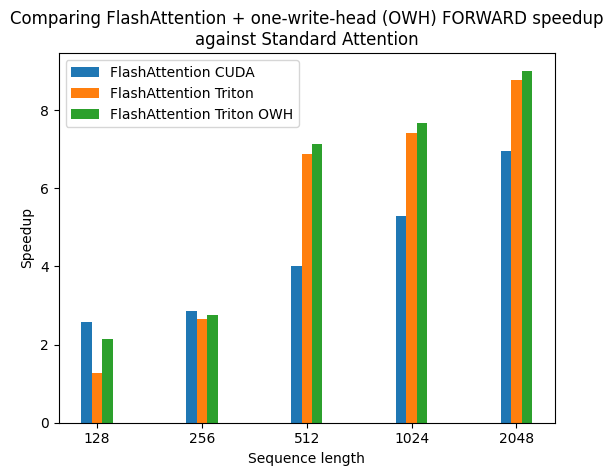

In [40]:
import matplotlib.pyplot as plt
import numpy as np

seqlen_str=[str(v) for v in seqlen2]

ax=plt.gca()
ax.bar(x=np.arange(len(seqlen_str))-.1,height=[standardattention_time[idx]/flashattention_time[idx] for idx in range(len(seqlen_str))],width=.1)
ax.bar(x=np.arange(len(seqlen_str)),height=[standardattention_time[idx]/flashattentiontriton_time[idx] for idx in range(len(seqlen_str))],width=.1)
ax.bar(x=np.arange(len(seqlen_str))+.1,height=[standardattention_time[idx]/flashattentiontritonOWH_time[idx] for idx in range(len(seqlen_str))],width=.1)
ax.set_xticks(range(len(seqlen_str)))
ax.set_xticklabels(seqlen_str)
ax.set_xlabel("Sequence length")
ax.set_ylabel("Speedup")
ax.set_title("Comparing FlashAttention + one-write-head (OWH) FORWARD speedup\nagainst Standard Attention")
ax.legend(["FlashAttention CUDA","FlashAttention Triton","FlashAttention Triton OWH"])

In [41]:
# Extract backward-pass analysis data from results data structures

#seqlens=[]
standardattention_time=[]
standardattention_memory=[]
flashattention_time=[]
flashattention_memory=[]
flashattentiontriton_time=[]
flashattentiontriton_memory=[]
flashattentiontritonOWH_time=[]
flashattentiontritonOWH_memory=[]

for s in res2:
    standardattention_time.append(s['StandardAttentionBackward pass'])
    standardattention_memory.append(s['StandardAttentionForward + Backward passMaxMemory'])    
    flashattention_time.append(s['FlashAttentionBackward pass'])
    flashattention_memory.append(s['FlashAttentionForward + Backward passMaxMemory'])
    flashattentiontriton_time.append(s['FlashAttention TritonBackward pass'])
    flashattentiontriton_memory.append(s['FlashAttention TritonForward + Backward passMaxMemory'])
    flashattentiontritonOWH_time.append(s['FlashAttention Triton OWHBackward pass'])
    flashattentiontritonOWH_memory.append(s['FlashAttention Triton OWHForward + Backward passMaxMemory'])

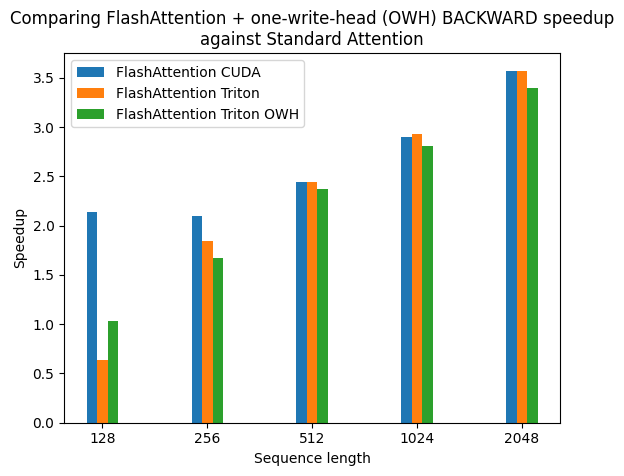

In [42]:
import matplotlib.pyplot as plt
import numpy as np

seqlen_str=[str(v) for v in seqlen2]

ax=plt.gca()
ax.bar(x=np.arange(len(seqlen_str))-.1,height=[standardattention_time[idx]/flashattention_time[idx] for idx in range(len(seqlen_str))],width=.1)
ax.bar(x=np.arange(len(seqlen_str)),height=[standardattention_time[idx]/flashattentiontriton_time[idx] for idx in range(len(seqlen_str))],width=.1)
ax.bar(x=np.arange(len(seqlen_str))+.1,height=[standardattention_time[idx]/flashattentiontritonOWH_time[idx] for idx in range(len(seqlen_str))],width=.1)
ax.set_xticks(range(len(seqlen_str)))
ax.set_xticklabels(seqlen_str)
ax.set_xlabel("Sequence length")
ax.set_ylabel("Speedup")
ax.set_title("Comparing FlashAttention + one-write-head (OWH) BACKWARD speedup\nagainst Standard Attention")
ax.legend(["FlashAttention CUDA","FlashAttention Triton","FlashAttention Triton OWH"])

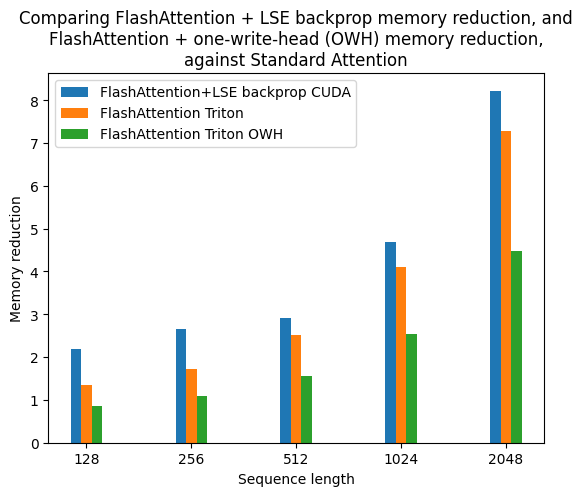

In [38]:
import matplotlib.pyplot as plt
import numpy as np

seqlen_str=[str(v) for v in seqlen2]

ax=plt.gca()
ax.bar(x=np.arange(len(seqlen_str))-.1,height=[standardattention_memory[idx]/flashattention_memory[idx] for idx in range(len(seqlen_str))],width=.1)
ax.bar(x=np.arange(len(seqlen_str)),height=[standardattention_memory[idx]/flashattentiontriton_memory[idx] for idx in range(len(seqlen_str))],width=.1)
ax.bar(x=np.arange(len(seqlen_str))+.1,height=[standardattention_memory[idx]/flashattentiontritonOWH_memory[idx] for idx in range(len(seqlen_str))],width=.1)
ax.set_xticks(range(len(seqlen_str)))
ax.set_xticklabels(seqlen_str)
ax.set_xlabel("Sequence length")
ax.set_ylabel("Memory reduction")
ax.set_title("Comparing FlashAttention + LSE backprop memory reduction, and\nFlashAttention + one-write-head (OWH) memory reduction,\nagainst Standard Attention")
ax.legend(["FlashAttention+LSE backprop CUDA","FlashAttention Triton","FlashAttention Triton OWH"])